# Star Variability Machine Learning

## Overview
We looked at data that the ESA's Hipparcos satellite gathered between 1989 and 1993 and made a machine learning model to predict whether a star is variable or not. The data we used can be found [here.](https://www.kaggle.com/datasets/konivat/hipparcos-star-catalog)

## Business Understanding
NASA wants us to get a list of stars our model expects to be variable. They'd rather look at stars that turn out not to be variable than miss stars that are variable, so we want to optimize our recall more than precision.

## Data Cleaning
This data had a lot of features, and a lot of null values. The first thing we did with the data was separate it into two datasets; one where the target is null and one where it is not.

After that, we needed to look at our target and understand what we should put as 0 and what should be 1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, plot_confusion_matrix, confusion_matrix, plot_roc_curve, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [2]:
def display_metrics(fit_model, Xtr, Xte, ytr, yte):
    '''
    This function takes in a model that's already been fit, then X and y train and test data.
    It uses the fitted model to get predicted values for the train and test data,
    and then uses sklearn's score functions to print out the accuracy, recall, precision,  f1, and roc-auc scores.
    It then plots a confusion matrix of the test data.
    '''
    train_preds = fit_model.predict(Xtr)
    test_preds = fit_model.predict(Xte)
    train_probs = fit_model.predict_proba(Xtr)[:,1]
    test_probs = fit_model.predict_proba(Xte)[:,1]

    train_accuracy = accuracy_score(ytr, train_preds)
    test_accuracy = accuracy_score(yte, test_preds)
    train_recall = recall_score(ytr, train_preds, zero_division=0)
    test_recall = recall_score(yte, test_preds, zero_division=0)
    train_precision = precision_score(ytr, train_preds, zero_division=0)
    test_precision = precision_score(yte, test_preds, zero_division=0)
    train_f1 = f1_score(ytr, train_preds, zero_division=0)
    test_f1 = f1_score(yte, test_preds, zero_division=0)
    train_rocauc = roc_auc_score(ytr, train_probs)
    test_rocauc = roc_auc_score(yte, test_probs)

    print(F'\nTrain Accuracy:\t\t{train_accuracy}')
    print(F'Test Accuracy:\t\t{test_accuracy}')
    print(F"\nTrain Recall:\t\t{train_recall}")
    print(F'Test Recall:\t\t{test_recall}')
    print(F"\nTrain Precision:\t{train_precision}")
    print(F'Test Precision:\t\t{test_precision}')
    print(F"\nTrain f1:\t\t{train_f1}")
    print(F'Test f1:\t\t{test_f1}')
    print(F"\nTrain ROC-AUC:\t\t{train_rocauc}")
    print(F'Test ROC-AUC:\t\t{test_rocauc}')
    
    plot_confusion_matrix(fit_model, Xte, yte)

After looking into our target and the meanings of all the values, we determined everything except 'C' indicated the star was variable, so we set every other value equal to a placeholder and used a mask with the map function to set C equal to 0 and V equal to 1.

In [3]:
# Read in dataframes and drop unneeded index col
df = pd.read_csv("data/UsableData.csv")
holdoutdf = pd.read_csv("data/UntestableData.csv")
df = df.drop(columns=['Unnamed: 0'])

# Assign values other than C to the value V
df['HvarType'] = df['HvarType'].mask(df['HvarType'] != 'C', other='V')

# Create a mask and map C to 0 and V to 1
mask = {
    'C': 0,
    'V': 1
}

# Apply the mask
df['Target'] = df['HvarType'].map(mask)

Data exploration showed that there were some columns that would not be useful or usable for predicting variability. These columns include unique identifiers like HIP, HD and CoD, but it also included features that are always null when the star is unclassified like Period and VarFlag. So, we drop those columns before doing anything else.

In [4]:
df = df.drop(columns=['Catalog', 'VarFlag', '---', 'Period', 'moreVar', 'morePhoto', 'Source', 'HIP', 'HD', 'BD', 'CoD', 'CPD'])
holdoutdf = holdoutdf.drop(columns=['Unnamed: 0', 'Catalog', 'VarFlag', '---', 'Period', 'moreVar', 'morePhoto', 'Source', 'HD', 'BD', 'CoD', 'CPD', 'HvarType'])

We then separate our x data into everything except our target, and our y to only include the target, and we split into train and test data.

In [5]:
X = df.drop(columns=['HvarType','Target'])
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [6]:
y.value_counts(normalize=True)

0    0.649968
1    0.350032
Name: Target, dtype: float64

Looking at our target value, we do see a class imbalance of 65% non-variable to 35% variable. This is a small enough imbalance that we won't worry about over or undersampling to deal with it, but still needs to be accounted for when we look at our metrics.

We explored the data to gain an understanding of how we should preprocess each column of our data, so we have take all of those different methods and defined them; then we put them all into 1 sklearn pipeline so that we can use the preprocessor before modeling.

In [7]:
# Object columns that get imputed with the most common value
mode_cols = ['r_B-V','r_V-I','r_Vmag']
mode_imp = Pipeline(steps=[
    ('mode_imp', SimpleImputer(strategy='most_frequent')),
    ('mode_enc', OneHotEncoder(handle_unknown='ignore', sparse=True))
])

# Object columns that get imputed with the string 'Null as an indicator'
const_cols = ['AstroRef','m_BTmag','CombMag','Proxy','m_Hpmag','CCDM','n_CCDM','MultFlag','Qual','Survey',
              'Chart','Notes','r_SpType']
const_imp = Pipeline(steps=[
    ('const_imp', SimpleImputer(strategy='constant',fill_value='Null')),
    ('const_enc', OneHotEncoder(handle_unknown='ignore', sparse=True))
])

# Numeric columns that get imputed with the mean
num_cols = ['Vmag', "RAdeg", 'DEdeg', 'Plx', 'pmRA', 'pmDE', 'e_RAdeg', 'e_DEdeg', 'e_Plx', 'e_pmRA',
           'e_pmDE', 'DE:RA', 'Plx:RA', 'Plx:DE', 'pmRA:RA', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE',
           'pmDE:Plx', 'pmDE:pmRA', 'F1', 'F2', 'BTmag', 'VTmag', 'e_VTmag', 'B-V', 'e_B-V', 'V-I', 'e_V-I',
           'Hpmag', 'e_Hpmag', 'Hpscat', 'o_Hpmag', 'Hpmax', 'HPmin', 'rho', 'e_rho', 'dHp', 'e_dHp', '(V-I)red']
num_imp = Pipeline(steps=[
    ('num_imp',SimpleImputer(strategy='mean'))
])

# Numeric column that gets imputed with the mean and gets a missing indicator
missing_ind_cols = ['theta']
missing_ind_imp = Pipeline(steps=[
    ('missing_ind_imp', SimpleImputer(strategy='mean', add_indicator=True))
])

# Numeric columns that get filled with the value of 1.0
num_const_cols = ['Nsys', 'Ncomp']
num_const_imp = Pipeline(steps=[
    ('num_const_imp', SimpleImputer(strategy='constant', fill_value=1.0))
])

# List of every column the preprocessor takes in
use_cols = [*mode_cols, *const_cols, *num_cols, *missing_ind_cols, *num_const_cols]

# Column lists for final model
final_const_cols = ["Ncomp", "Nsys"]
final_mean_cols = ["Hpmax", "Hpscat", "e_Hpmag", 'B-V', 'VTmag', 'e_VTmag']
final_cols = [*final_mean_cols, *final_const_cols]

In [8]:
# Preprocessor that uses all data
full_preprocessor = ColumnTransformer(transformers=[
    ('mode_pre',mode_imp,mode_cols),
    ('const_pre',const_imp,const_cols),
    ('num_pre',num_imp,num_cols),
    ('missing_ind_pre',missing_ind_imp,missing_ind_cols),
    ('num_const_pre',num_const_imp,num_const_cols)
])

# Preprocessor that takes only numeric data
final_preprocessor = ColumnTransformer(transformers=[
    ('final_pre', num_imp, final_mean_cols),
    ('final_const_pre', num_const_imp, final_const_cols)
])

## Modeling
### Initial Model
With the preprocessor made, we started with a logistic regression that took in all of our data. Many of our features have multicolinearity, and the relationships may not be truly linear, but the logistic regression could still be useful with that in mind.


Train Accuracy:		0.9386402561620374
Test Accuracy:		0.920808667485759

Train Recall:		0.8375758866758973
Test Recall:		0.8278766687857597

Train Precision:	0.9845999749593088
Test Precision:		0.9395743145743146

Train f1:		0.9051565377532229
Test f1:		0.8801960121662723

Train ROC-AUC:		0.9507569472867662
Test ROC-AUC:		0.9377961397839445


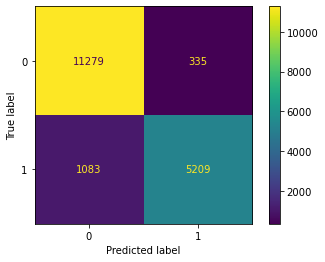

In [9]:
sink_logreg = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('logreg', LogisticRegression(max_iter=5000, random_state=42))
])

sink_logreg.fit(X_train[use_cols],y_train)

display_metrics(sink_logreg, X_train[use_cols], X_test[use_cols], y_train, y_test)

This model is fairly accurate, even accounting for our class imbalance. However, it does fall short in recall, with more false negatives than we'd like.

### Intermediate Models
After the logistic regression performed quite well, we tried different model type; we did naive bayes and decision tree models.

The naive bayes model required a change to the preprocessor to pass a dense matrix, but it didn't perform well, so we scrapped it right away. It makes sense that the naive bayes model didn't perform well because the nb model operates under the assumption that all features are independent from each other, which is not true in this case.

Since the naive bayes model didn't look promising, we moved on to a decision tree to see if that would perform better than our logistic regression using the same method of throwing all of the data into the tree. We started with an untuned tree, which was very overfit, but after some initial tuning we got a more useful model.


Train Accuracy:		0.9421215280363393
Test Accuracy:		0.9254439852563386

Train Recall:		0.8812440089466397
Test Recall:		0.8569612205975843

Train Precision:	0.949561025994147
Test Precision:		0.9253475201647503

Train f1:		0.9141278828891037
Test f1:		0.8898423962373134

Train ROC-AUC:		0.9788541145396515
Test ROC-AUC:		0.9527709490518874


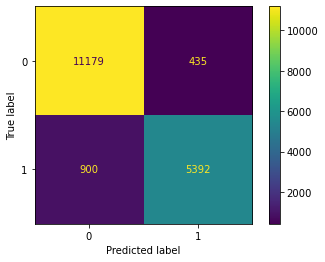

In [10]:
sink_tree = Pipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('tree', DecisionTreeClassifier(max_depth=20, min_samples_leaf=20,random_state=42))
])

sink_tree.fit(X_train[use_cols],y_train)

display_metrics(sink_tree, X_train[use_cols], X_test[use_cols], y_train, y_test)

This model produces fewer false negatives, but does produce more false positives. This is a worthwhile tradeoff for our purposes, especially since further tuning could further improve this model, so we focused our final modeling on improving our scores for a tree based model.

### Final Model
So after those initial models, we experimented with decision trees. Our explorations showed that the object columns were not helping our model, so we moved on to only using our numeric values.


Train Accuracy:		0.9361642713530419
Test Accuracy:		0.9273986373282699

Train Recall:		0.8733624454148472
Test Recall:		0.8674507310870947

Train Precision:	0.939774224972781
Test Precision:		0.9213369345037137

Train f1:		0.9053520660244556
Test f1:		0.8935821872953503

Train ROC-AUC:		0.9636522886751335
Test ROC-AUC:		0.9503471953473519


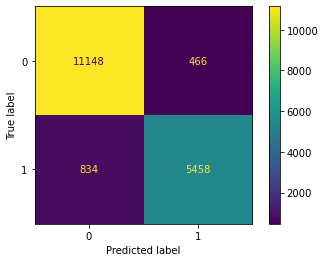

In [11]:
final_model = Pipeline(steps=[
    ('preprocessor', final_preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=74))
])
final_model.fit(X_train[final_cols], y_train)

display_metrics(final_model, X_train[final_cols], X_test[final_cols], y_train, y_test)

## Results
So now that we have our final model, we want to grab the stars that were unclassified in the hipparcos data and predict on them, and then we can save that list.

In [12]:
holdout_preds = final_model.predict(holdoutdf[final_cols])
holdoutdf['Predicted'] = holdout_preds

predicted_variable_HIP = list(holdoutdf[holdoutdf['Predicted'] == 1]['HIP'])

In [13]:
display(predicted_variable_HIP)

[6,
 16,
 22,
 62,
 65,
 75,
 83,
 89,
 101,
 126,
 127,
 145,
 160,
 166,
 172,
 189,
 191,
 196,
 218,
 260,
 279,
 307,
 347,
 350,
 352,
 353,
 354,
 377,
 393,
 403,
 435,
 444,
 445,
 459,
 464,
 469,
 483,
 487,
 488,
 496,
 499,
 507,
 549,
 558,
 559,
 561,
 564,
 568,
 584,
 592,
 622,
 644,
 654,
 666,
 673,
 685,
 692,
 714,
 731,
 738,
 743,
 773,
 776,
 777,
 801,
 862,
 872,
 898,
 934,
 947,
 965,
 990,
 992,
 997,
 1001,
 1006,
 1021,
 1023,
 1050,
 1059,
 1066,
 1081,
 1083,
 1091,
 1097,
 1098,
 1104,
 1129,
 1165,
 1171,
 1181,
 1183,
 1195,
 1198,
 1204,
 1208,
 1214,
 1227,
 1244,
 1270,
 1278,
 1276,
 1293,
 1295,
 1302,
 1313,
 1322,
 1345,
 1357,
 1386,
 1391,
 1410,
 1418,
 1426,
 1438,
 1454,
 1459,
 1505,
 1511,
 1530,
 1533,
 1542,
 1544,
 1546,
 1586,
 1589,
 1592,
 1608,
 1640,
 1676,
 1689,
 1693,
 1703,
 1749,
 1781,
 1801,
 1811,
 1813,
 1842,
 1850,
 1867,
 1902,
 1920,
 1959,
 1972,
 1987,
 2026,
 2051,
 2055,
 2070,
 2071,
 2081,
 2097,
 2131,
 2147

### Conclusion
So now we have a list of stars predicted to be variable for NASA to observe. If given more time, we could further refine our model with a bit more feature engineering and model tuning to produce more accurate predictions.

# Delete below cell when done with final notebook and readme

In [14]:
y_pred = final_model.predict(X_test[final_cols])

final_conf_mat = confusion_matrix(y_test, y_pred)

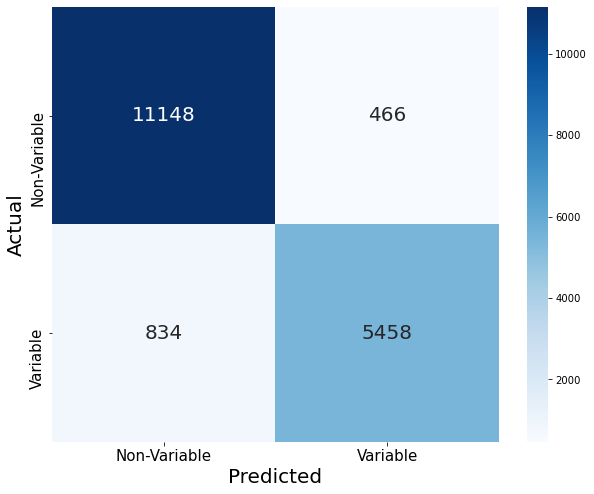

In [15]:
fig, ax = plt.subplots(figsize=(10,8));

sns.heatmap(data=final_conf_mat, fmt='g', cmap='Blues', annot=True, annot_kws={"size": 20});

ax.set()
ax.set_xticklabels(['Non-Variable', "Variable"], fontsize=15)
ax.set_yticklabels(['Non-Variable', 'Variable'],fontsize=15)
ax.set_xlabel('Predicted', fontsize=20);
ax.set_ylabel('Actual', fontsize=20);

# plt.savefig(fname='FinalConfusionMatrix.png', format='jpg', bbox_inches='tight')